<h1>1. Initial Imports</h1>

In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
# os.environ['TF_CUDNN_RESET_RND_GEN_STATE'] = '1' 
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' 
# os.environ['CUDA_VISIBLE_DEVICES'] = '' 
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=4096'

In [5]:
pin_name = "ResNet152-GRU-Flickr8k-FastText-BahdanauAttention-Indo-Z2"
base_dir = "/"
dataset_dir = 'dataset/flickr30k'

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

import fasttext
import heapq
from tqdm import tqdm

#custom imports data_loader on root dir
from data_loader import FlickrDataset, get_data_loader

<h1>2. Show Image Function</h1>

In [4]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.cpu().numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

<h1>3. Init Config Dataset and Dataloader</h1>

In [6]:
#setting the constants
BATCH_SIZE = 128
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = dataset_dir+'/images',
    caption_file = dataset_dir+"/flickr30k-id-train-pin.csv",
    transform=transforms,
    freq_threshold=5
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)

#vocab_size
vocab_size = len(dataset.vocab)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

<h1>4. Info Dataset</h1>

In [9]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import string

In [10]:
file_path = dataset_dir+"/flickr30k-id-train-pin.csv"
xdf = pd.read_csv(file_path)

captions = xdf['caption']

In [11]:
# Get the English stopwords list from NLTK
stopwords_en = set(stopwords.words('indonesian'))

# Initialize a Counter to count the words
word_counts = Counter()

In [12]:
# Define a function to tokenize, remove stopwords, and punctuation
def tokenize_and_remove_stopwords(caption):
    # Tokenize the caption into words
    words = dataset.vocab.tokenize(caption)
    # Remove stopwords and punctuation
    words = [word for word in words if word.lower() not in stopwords_en and word not in string.punctuation]
    return words

# Iterate over captions, tokenize each caption, and count words
for caption in captions:
    # Tokenize the caption into words
    caption = tokenize_and_remove_stopwords(caption)
    words = dataset.vocab.tokenize(' '.join(caption))
    word_counts.update(words)
    
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
sorted_word_counts[:5]
# Print the sorted word counts
# for idx, (word, count) in tqdm(enumerate(sorted_word_counts)):
#     if count < 5:
#         del sorted_word_counts[idx]

[('pria', 44662),
 ('wanita', 26166),
 ('orang', 20379),
 ('anak', 17327),
 ('mengenakan', 15134)]

In [13]:
# sorted_word_counts.pop(0)
sorted_word_counts[-5:]

[('eksoti', 1),
 ('camcorde', 1),
 ('cocker', 1),
 ('anggun', 1),
 ('bergulung-gulung', 1)]

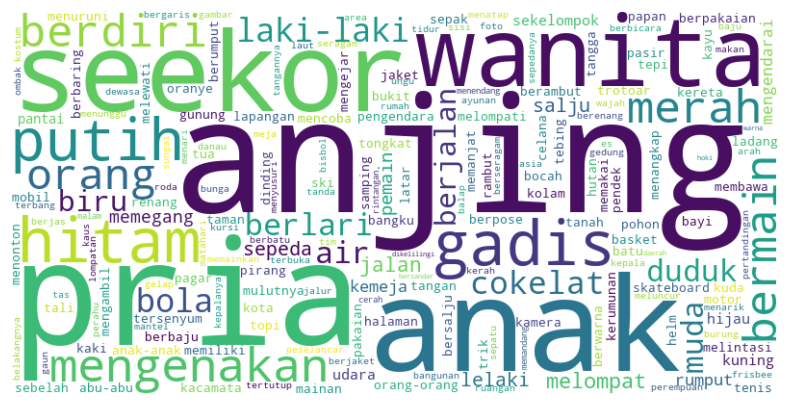

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_counts_dict = {word: count for word, count in sorted_word_counts}
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(word_counts_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('plot/flickr8k-id-train-pin-wordcloud.png', bbox_inches='tight')
plt.show()

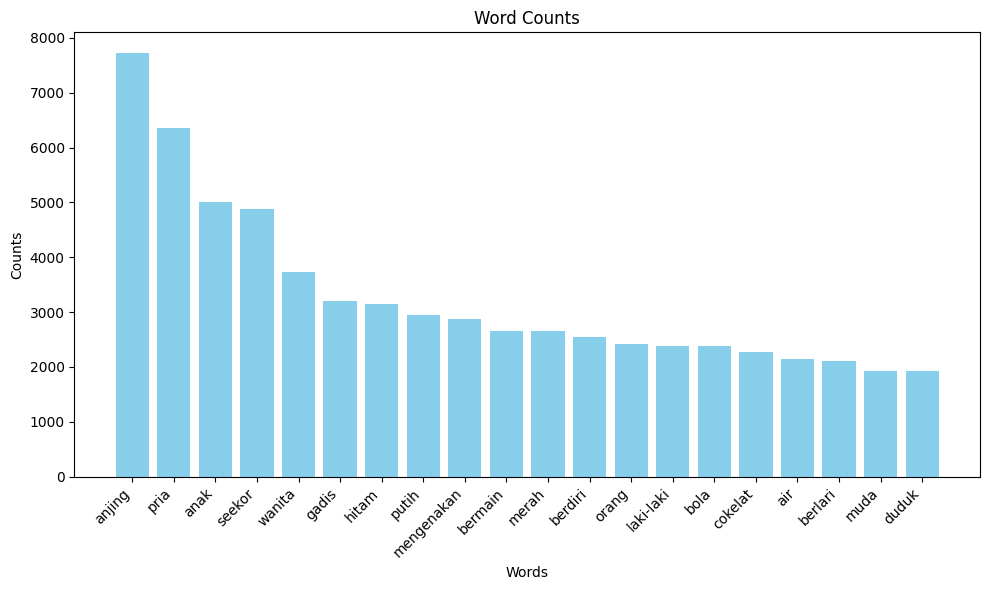

In [15]:
# Extract words and counts from the sorted word counts
words = [pair[0] for pair in sorted_word_counts[:20]]
counts = [pair[1] for pair in sorted_word_counts[:20]]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')

# Add labels and title
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Counts')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.savefig('plot/flickr8k-id-train-pin-bar.png', bbox_inches='tight')
plt.show()

<h1>5. Set Word Embedding Use FastText</h1>

In [16]:
import fasttext.util
fasttext.FastText.eprint = lambda x: None
ft = fasttext.load_model('fasttext/cc.id.300.bin')

# embedding_matrix = torch.FloatTensor(ft.get_input_matrix())
# # ft.get_nearest_neighbors('malam')

# Get the dimension of the FastText word vectors
embedding_dim = ft.get_dimension()

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with FastText word vectors
for key, word in enumerate(dataset.vocab.itos.items()):
    if word[1] in ft.words:
        # print(key, word[1])
        # print(ft.get_word_vector(word[1]))
        # print(ft.get_nearest_neighbors('anjing'))
        embedding_matrix[key] = ft.get_word_vector(word[1])

del ft

# # Convert the embedding matrix to a PyTorch tensor
embedding_matrix = torch.Tensor(embedding_matrix)

In [17]:
embed_weights = {
    "embedding_matrix": embedding_matrix
}

torch.save(embed_weights, 'weights/fasttext-flickr8k-fin.pt')

In [18]:
# embed_weights = torch.load('weights/fasttext-flickr8k_id_min.pt')
# embedding_matrix = embed_weights['embedding_matrix']

In [19]:
len(embedding_matrix[1])

300

<h1>6. Defining the Model Architecture</h1>

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

In [21]:
class EncoderCNN(nn.Module):
    """Encodes images using a pre-trained ResNet model.

    Args:
        pretrained (bool): If True, use a pre-trained ResNet model.

    Attributes:
        base_model (nn.Module): The pre-trained ResNet model.
        fine_tune_status (bool): Whether the model is fine-tuned.

    """
    def __init__(self):
        super().__init__()
        # resnet = models.resnet50(pretrained=True)
        arch = models.resnet152(weights='IMAGENET1K_V1')
        for param in arch.parameters():
            param.requires_grad_(False)
            
        modules = list(arch.children())[:-2]
        self.arch = nn.Sequential(*modules)
        self.fine_tune_status = False
        
    def forward(self, images):
        features = self.arch(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

    def fine_tune(self, status=False):
        self.fine_tune_status = status
        if not status:
            for param in self.arch.parameters():
                param.requires_grad_(False)
        else:
            for module in list(self.arch.children())[7:]:
                for param in module.parameters():
                    param.requires_grad_(True)

In [22]:
class DecoderRNN(nn.Module):
    """Recurrent decoder with attention for image captioning.

    Args:
        num_layers (int): Number of stacked GRU layers.
        embed_size (int): Size of the word embedding vectors.
        vocab_size (int): Size of the vocabulary.
        attention_dim (int): Dimension of the attention layer.
        encoder_dim (int): Dimension of the encoder features.
        decoder_dim (int): Dimension of the decoder's hidden state.
        word_vector (torch.Tensor): Pre-trained word embedding vectors.
        drop_prob (float): Dropout probability (default: 0.5).
    """
    def __init__(self, num_layers, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, word_vector, drop_prob=0.5):
        super().__init__()

        # Save model parameters
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.num_layers = num_layers

        # Initialize embedding layer with pretrained word vectors
        # self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding = nn.Embedding.from_pretrained(word_vector, freeze=True)

        # Attention mechanism
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        # Initialize linear layer for initializing hidden state
        self.init_h = nn.Linear(encoder_dim, decoder_dim)

        # Define GRU layers
        self.gru_layers = nn.ModuleList([nn.GRUCell(embed_size + encoder_dim if layer == 0 else decoder_dim, decoder_dim) for layer in range(num_layers)])

        # Define output layer
        self.fcn = nn.Linear(decoder_dim, vocab_size)

        # Dropout layer
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        """Performs the forward pass of the decoder.

        Args:
            features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim).
            captions (torch.Tensor): Input captions (batch_size, caption_length).
    
        Returns:
            tuple:
                - preds (torch.Tensor): Predicted word scores (batch_size, caption_length, vocab_size).
                - alphas (torch.Tensor): Attention weights (batch_size, caption_length, num_features).
        """
        embeds = self.embedding(captions)
        h = self.init_hidden_state(features)
        seq_length = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)

        for s in range(seq_length):
            alpha, context = self.attention(features, h[-1])  # Use the last hidden state
            gru_input = torch.cat((embeds[:, s], context), dim=1)

            for layer in range(self.num_layers):
                h[layer] = self.gru_layers[layer](gru_input, h[layer])
                gru_input = h[layer]

            output = self.fcn(self.drop(gru_input))
            preds[:, s] = output
            alphas[:, s] = alpha

        return preds, alphas

    def generate_caption(self, features, beam_width=5, max_len=100, vocab=None):
        """Performs the forward pass of the decoder.

        Args:
            features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim).
            captions (torch.Tensor): Input captions (batch_size, caption_length).
    
        Returns:
            tuple:
                - preds (torch.Tensor): Predicted word scores (batch_size, caption_length, vocab_size).
                - alphas (torch.Tensor): Attention weights (batch_size, caption_length, num_features).
        """
        batch_size = features.size(0)
        alphas = []
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        # Initialize the beam search starting with '<SOS>' token
        h = self.init_hidden_state(features)  # Initialize hidden state
        beams = [([], 0, h, embeds, []) for _ in range(beam_width)]
        all_captions = []

        for _ in range(max_len):
            next_beams = []
            for caption, log_prob, h, prev_embeds, indices in beams:
                # If the last token in the caption is '<EOS>', add it to all_captions
                if len(caption) > 0 and caption[-1] == vocab.stoi['<EOS>']:
                    all_captions.append((caption, log_prob))
                    continue

                # Generate the next token
                alpha, context = self.attention(features, h[-1])
                alphas.append(alpha.cpu().detach().numpy())
                gru_input = torch.cat((prev_embeds[:, 0], context), dim=1)
                h_new = []
                for layer in range(self.num_layers):
                    h_layer = self.gru_layers[layer](gru_input, h[layer])
                    h_new.append(h_layer)
                    gru_input = h_layer
                output = self.fcn(self.drop(gru_input))
                log_probs = F.log_softmax(output, dim=1)

                # Apply beam search
                top_log_probs, top_indices = torch.topk(log_probs, beam_width)
                for i in range(beam_width):
                    next_token = top_indices[0][i].item()
                    next_log_prob = top_log_probs[0][i].item()
                    next_caption = caption + [next_token]
                    next_h = [h_i.clone() for h_i in h_new]  # Clone the hidden states
                    next_embeds = self.embedding(torch.tensor([[next_token]]).to(device))
                    next_beams.append((next_caption, log_prob + next_log_prob, next_h, next_embeds, indices + [next_token]))

            # Select the top beams
            beams = heapq.nlargest(beam_width, next_beams, key=lambda x: x[1])

        # Add remaining beams to all_captions
        all_captions.extend([(caption, log_prob) for caption, log_prob, _, _, _ in beams])

        # Select the beam with the highest probability
        best_caption, _ = max(all_captions, key=lambda x: x[1])

        return [vocab.itos[idx] for idx in best_caption], alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = [self.init_h(mean_encoder_out) for _ in range(self.num_layers)]
        return h

In [23]:
# class DecoderRNN(nn.Module):
#     """Recurrent decoder with attention for image captioning using LSTM.

#     Args:
#         num_layers (int): Number of stacked LSTM layers.
#         embed_size (int): Size of the word embedding vectors.
#         vocab_size (int): Size of the vocabulary.
#         attention_dim (int): Dimension of the attention layer.
#         encoder_dim (int): Dimension of the encoder features.
#         decoder_dim (int): Dimension of the decoder's hidden state.
#         word_vector (torch.Tensor): Pre-trained word embedding vectors.
#         drop_prob (float): Dropout probability (default: 0.5).
#     """
#     def __init__(self, num_layers, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, word_vector, drop_prob=0.5):
#         super().__init__()
        
#         # Save the model parameters
#         self.vocab_size = vocab_size
#         self.attention_dim = attention_dim
#         self.decoder_dim = decoder_dim
#         self.num_layers = num_layers
        
#         self.embedding = nn.Embedding(vocab_size, embed_size)
        
#         self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
#         self.init_h = nn.Linear(encoder_dim, decoder_dim)
#         self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Initialize the cell state for LSTM
        
#         # Define the LSTM layers
#         self.lstm_layers = nn.ModuleList([nn.LSTMCell(embed_size + encoder_dim if layer == 0 else decoder_dim, decoder_dim) for layer in range(num_layers)])
        
#         self.fcn = nn.Linear(decoder_dim, vocab_size)
#         self.drop = nn.Dropout(drop_prob)

#     def forward(self, features, captions):
#         """Performs the forward pass of the decoder.

#         Args:
#             features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim).
#             captions (torch.Tensor): Input captions (batch_size, caption_length).
    
#         Returns:
#             tuple:
#                 - preds (torch.Tensor): Predicted word scores (batch_size, caption_length, vocab_size).
#                 - alphas (torch.Tensor): Attention weights (batch_size, caption_length, num_features).
#         """
#         embeds = self.embedding(captions)
#         h = self.init_hidden_state(features)
#         c = self.init_cell_state(features)
#         seq_length = len(captions[0]) - 1
#         batch_size = captions.size(0)
#         num_features = features.size(1)
        
#         preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
#         alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
#         for s in range(seq_length):
#             alpha, context = self.attention(features, h[-1])
#             lstm_input = torch.cat((embeds[:, s], context), dim=1)
            
#             for layer in range(self.num_layers):
#                 h[layer], c[layer] = self.lstm_layers[layer](lstm_input, (h[layer], c[layer]))
#                 lstm_input = h[layer]
            
#             output = self.fcn(self.drop(lstm_input))
#             preds[:, s] = output
#             alphas[:, s] = alpha  
        
#         return preds, alphas

#     def generate_caption(self, features, beam_width=3, max_len=100, vocab=None):
#         """Performs the forward pass of the decoder.

#         Args:
#             features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim).
#             captions (torch.Tensor): Input captions (batch_size, caption_length).
    
#         Returns:
#             tuple:
#                 - preds (torch.Tensor): Predicted word scores (batch_size, caption_length, vocab_size).
#                 - alphas (torch.Tensor): Attention weights (batch_size, caption_length, num_features).
#         """
#         batch_size = features.size(0)
#         h = self.init_hidden_state(features)
#         c = self.init_cell_state(features)
#         alphas = []
#         word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
#         embeds = self.embedding(word)
#         captions = []
        
#         for i in range(max_len):
#             alpha, context = self.attention(features, h[-1])
#             alphas.append(alpha.cpu().detach().numpy())
#             lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            
#             for layer in range(self.num_layers):
#                 h[layer], c[layer] = self.lstm_layers[layer](lstm_input, (h[layer], c[layer]))
#                 lstm_input = h[layer]
            
#             output = self.fcn(self.drop(lstm_input))
#             output = output.view(batch_size, -1)
#             predicted_word_idx = output.argmax(dim=1)
#             captions.append(predicted_word_idx.item())
            
#             if vocab.itos[predicted_word_idx.item()] == "<EOS>":
#                 break
            
#             embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
#         return [vocab.itos[idx] for idx in captions], alphas
    
#     def init_hidden_state(self, encoder_out):
#         mean_encoder_out = encoder_out.mean(dim=1)
#         h = [self.init_h(mean_encoder_out) for _ in range(self.num_layers)]
#         return h
    
#     def init_cell_state(self, encoder_out):
#         mean_encoder_out = encoder_out.mean(dim=1)
#         c = [self.init_c(mean_encoder_out) for _ in range(self.num_layers)]
#         return c

In [24]:
class EncoderDecoder(nn.Module):
    """Image captioning model combining CNN encoder and RNN decoder with attention.

    Args:
       num_layers (int): Number of layers in the decoder's RNN.
       embed_size (int): Size of word embedding vectors.
       vocab_size (int): Size of the vocabulary.
       attention_dim (int): Dimension of the attention layer.
       encoder_dim (int): Dimension of the encoder's output features.
       decoder_dim (int): Dimension of the decoder's hidden state.
       word_vector (torch.Tensor): Pre-trained word embedding vectors.
       drop_prob (float): Dropout probability (default: 0.3).
    """ 
    def __init__(self, num_layers, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, word_vector, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            num_layers=num_layers,
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            word_vector=word_vector
        )
        
    def forward(self, images, captions):
        """Performs image captioning.

        Args:
            images (torch.Tensor): Input images (batch_size, num_channels, height, width).
            captions (torch.Tensor): Caption word indices (batch_size, caption_length).

        Returns:
            torch.Tensor: Predicted vocabulary scores for each word in the caption.
        """
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [25]:
#Bahdanau Attention
class Attention(nn.Module):
    """Implements Bahdanau Attention for focusing on relevant input features.

    Args:
        encoder_dim (int): Dimension of the encoder output features.
        decoder_dim (int): Dimension of the decoder's hidden state.
        attention_dim (int): Dimension of the intermediate attention layer.

    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)

        self.A = nn.Linear(attention_dim,1)


    def forward(self, features, hidden_state):
        """Calculates attention weights and the attention-weighted context vector.

        Args:
            features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim)
            hidden_state (torch.Tensor): Current decoder hidden state (batch_size, decoder_dim)

        Returns:
            tuple:
                - alpha (torch.Tensor): Attention weights (batch_size, num_layers)
                - attention_weights (torch.Tensor): Context vector (batch_size, encoder_dim)
        """
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)


        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)

        return alpha,attention_weights

<h1>7. Settings Hyperparam And Init The Model</h1>

In [26]:
# Init model
model = None
is_new_model = False
embed_size=len(embedding_matrix[1])
vocab_size = len(dataset.vocab)
attention_dim=128
encoder_dim=2048
decoder_dim=512
num_layers=3
learning_rate = 5e-4
fine_tune=True
loss_history = []

In [27]:
def load_model(filepath):
    # Load the model state dictionary
    model_state = torch.load(filepath)
    
    loaded_model = EncoderDecoder(
        num_layers = num_layers,
        embed_size = model_state['embed_size'],
        vocab_size = model_state['vocab_size'],
        attention_dim = model_state['attention_dim'],
        encoder_dim = model_state['encoder_dim'],
        decoder_dim = model_state['decoder_dim'],
        word_vector = model_state['word_vector']
    ).to(device)
    
    # # Load the model state
    loaded_model.load_state_dict(model_state['state_dict'])
    
    return loaded_model, model_state['num_epochs'], model_state['loss_plot'], model_state['learning_rate'] if model_state['learning_rate'] else 5e-4

In [28]:
if os.path.exists('model/best-' + pin_name + '.pth'):
    model, num_epochs, loss_history, learning_rate = load_model('model/best-' + pin_name + '.pth')
    print(pin_name+' Model Has Loaded Succesfully !!!')
else:    
    model = EncoderDecoder(
        num_layers=num_layers,
        embed_size=embed_size,
        vocab_size=len(dataset.vocab),
        attention_dim=attention_dim,
        encoder_dim=encoder_dim,
        decoder_dim=decoder_dim,
        word_vector=embedding_matrix
    ).to(device)
    print(pin_name+' Model Has Created Succesfully !!!')
    is_new_model = True

ResNet152-GRU-Flickr8k-FastText-BahdanauAttention-Indo-Z2 Model Has Created Succesfully !!!


In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Optimizer dan criterion untuk encoder
encoder_criterion = nn.CrossEntropyLoss().to(device)
encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
encoder_scheduler = ReduceLROnPlateau(encoder_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Optimizer dan criterion untuk decoder
decoder_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).to(device)
decoder_optimizer = torch.optim.Adam(model.decoder.parameters(), lr=learning_rate)
decoder_scheduler = ReduceLROnPlateau(decoder_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [30]:
#helper function to save the model
def save_model(model, num_epochs, loss_plot, learning_rate, type):
    model_state = {
        'num_layers':num_layers,
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'word_vector':embedding_matrix,
        'state_dict':model.state_dict(),
        'loss_plot':loss_plot,
        'learning_rate':learning_rate
    }

    torch.save(model_state,'model/'+type+'-'+pin_name+'.pth')

In [31]:
model

EncoderDecoder(
  (encoder): EncoderCNN(
    (arch): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
   

<h1>8. Bleu Score Calculation Function</h1>

In [32]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def bleu_score(img_name, candidate_caption, reference_captions):    
    # Tokenize the reference and candidate captions
    reference_tokens = [word_tokenize(ref) for ref in reference_captions]
    candidate_tokens = word_tokenize(candidate_caption)
    
    # Calculate BLEU score for the candidate caption
    # Use smoothing function to handle cases with zero counts of n-gram overlaps
    smoother = SmoothingFunction()
    
    bleu_scores = []
    for n in range(1, 5):  # Calculate BLEU scores up to 4-grams
        bleu = sentence_bleu(reference_tokens, candidate_tokens, weights=[1.0/n] * n, smoothing_function=smoother.method1)
        bleu_scores.append(round(bleu, 4))
    
    return bleu_scores

In [33]:
def check_bleu(img_name, caption, df):
    reference_captions = df.loc[df['image'] == img_name]['caption'].tolist()
    reference_captions = [caption.lower().replace(".", "").strip() for caption in reference_captions]
    
    # reference_captions = [[caption] for caption in selected_captions]
    caption = caption.replace("<SOS>", "").replace("<EOS>", "").strip()
    # print("Caption: ", caption)
    # print("Ref Caption: ", reference_captions)
    bleu = bleu_score(img_name, caption, reference_captions)

    return bleu

<h1>9. Set Validation</h1>

In [34]:
import pandas as pd
df_val = pd.read_csv(dataset_dir+'/flickr8k-id-fin-valid.csv')
df_val.head()
val_list = df_val['image'].unique().tolist()

In [35]:
from PIL import Image
import random

def evaluate(model, device, val_list, validation_df):
    """
    Evaluates an image captioning model's performance on a set of validation images.

    Args:
        model (nn.Module): The image captioning model to evaluate.
        device (torch.device): The computational device for evaluation (CPU or GPU).
        val_list (list): List of image filenames (or paths) in the validation set.
        validation_df (pd.DataFrame): DataFrame with columns 'image' (image filenames) 
                                      and 'caption' (ground-truth captions).

    Returns:
        float: Average BLEU score across the validation set.
    """

    print('Validating...')
    model.eval()  # Set the model to evaluation mode 
    all_bleu_scores = []

    random.shuffle(val_list)

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for idx, image_filename in tqdm(enumerate(val_list)):
            # Image loading and preprocessing:
            image_path = dataset_dir+'/images/' + image_filename
            image = Image.open(image_path).convert('RGB')  # Load using PIL
            image = transforms(image)  # Apply your preprocessing (transforms function)
            image = image.unsqueeze(0).to(device)  # Add batch dimension, send to device

            # Feature extraction and caption generation:
            features = model.encoder(image) 
            generated_caption, _ = model.decoder.generate_caption(features, vocab=dataset.vocab)
            generated_caption = ' '.join(generated_caption)  # Convert words to sentence

            # Calculate and display BLEU score:
            bleu_scores = check_bleu(image_filename, generated_caption, validation_df)
            all_bleu_scores.append(bleu_scores)

            # Optional: Display generated caption every 50 images
            if (idx + 1) == len(val_list)-2:
                # print("Generated Caption:", generated_caption)
                show_image(image[0], title=generated_caption)  # Assuming you have 'show_image'

    # Calculate average BLEU score:
    average_bleu_scores = np.mean(all_bleu_scores, axis=0)
    return average_bleu_scores

<h1>10. Train The Model</h1>

In [36]:
def train_decoder(image, caption, device, decoder_optimizer, model, decoder_criterion):
    # print("Training Decoder:")
    model.encoder.fine_tune(False)
    
    for param in model.encoder.parameters():
        param.requires_grad = False
        
    for param in model.decoder.parameters():
        param.requires_grad = True
    
    # for idx, (images, captions) in tqdm(enumerate(data_loader)):
    decoder_optimizer.zero_grad()
    outputs, attentions = model(image, caption)
    loss_decoder = decoder_criterion(outputs.view(-1, vocab_size), caption[:, 1:].reshape(-1))  # Target is next word
    loss_decoder.backward()
    decoder_optimizer.step()

    return loss_decoder.item()

In [37]:
def train_encoder(image, caption, device, encoder_optimizer, model, encoder_criterion):
    # print("Training Encoder:")
    for param in model.decoder.parameters():
        param.requires_grad = False
        
    # for idx, (images, captions) in tqdm(enumerate(data_loader), total=len(data_loader)):
    encoder_optimizer.zero_grad()
    outputs, attentions = model(image, caption)
    loss_encoder = encoder_criterion(outputs.view(-1, vocab_size), caption[:, 1:].reshape(-1))  # Target is next word
    loss_encoder.backward()
    encoder_optimizer.step()
        
    return loss_encoder.item()

In [38]:
# from IPython.display import clear_output

def train_model(model, data_loader, num_epochs, device):
    """
    Train the image captioning model.
    
    Args:
      model (nn.Module): The image captioning model.
      data_loader (DataLoader): The data loader for the training set.
      criterion (nn.Module): The loss function.
      optimizer (Optimizer): The optimizer used for training.
      scheduler (ReduceLROnPlateau): The learning rate scheduler (optional).
      num_epochs (int): The number of epochs to train for.
      device (torch.device): The device to use for training (CPU or GPU).
      print_every (int, optional): How often to print training progress (default: 100).
    """
    encoder_loss_plot = []
    decoder_loss_plot = []
    loss_plot = [[],[]]
    best_bleu_score = [0,0,0,0]
    patience_counter = 0
    patience = 10
    
    for epoch in range(num_epochs):
        # clear_output(wait=True)  # Clear the output and wait for new output to replace it
        model.train()  # Set the model to training mode
        print(f'Epoch {epoch+1} :')
        
        decoder_loss_epoch = 0.0
        encoder_loss_epoch = 0.0
        
        for idx, (images, captions) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, captions = images.to(device), captions.to(device)
            decoder_loss_epoch += train_decoder(images, captions, device, decoder_optimizer, model, decoder_criterion)
            # if fine_tune:
            #     # print("Training Encoder:")
            #     model.encoder.fine_tune(True)
            #     encoder_loss_epoch += train_encoder(images, captions, device, encoder_optimizer, model, encoder_criterion)        
            # else:
            #     model.encoder.fine_tune(False)
                
        # encoder_loss_plot.append(encoder_loss_epoch/len(data_loader))
        decoder_loss_plot.append(decoder_loss_epoch/len(data_loader))
        loss_plot = [encoder_loss_plot, decoder_loss_plot]
    
        # Validation - calculate BLEU score (replace with your desired metric)
        bleu_score = evaluate(model, device, val_list, df_val)

        low_bleu_count = 0
        for current_bleu, best_bleu in zip(bleu_score, best_bleu_score):
            if current_bleu > best_bleu:
                low_bleu_count += 1
                
        if low_bleu_count >=1 :
            best_bleu_score = bleu_score
            save_model(model, num_epochs, loss_plot, decoder_optimizer.param_groups[0]['lr'], 'best')
            patience_counter = 0  # Reset patience counter
            print(f"Model Improved at Epoch: {epoch+1}")
        else:
            patience_counter += 1
        
        # Print and potentially save model checkpoint
        print(f"Epoch: {epoch+1}/{num_epochs}")
        print(f"Decoder Loss: {(decoder_loss_epoch/len(data_loader)):.4f}")
        # print(f"Encoder Loss: {encoder_loss_epoch:.4f}")
        print(f"BLEU Score: {bleu_score}")
        
        decoder_scheduler.step(decoder_loss_epoch)  # Adjust learning rate based on encoder loss
        # scheduler.step(encoder_loss_epoch)  # Adjust learning rate based on encoder loss

        # Print if scheduler is running
        if isinstance(decoder_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            print("Decoder scheduler is running")
        # if isinstance(encoder_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        #     print("Encoder scheduler is running")

        save_model(model, num_epochs, loss_plot, decoder_optimizer.param_groups[0]['lr'], 'last')
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in BLEU score")
            break
    
    return loss_plot

Epoch 1 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:17<00:00,  1.25s/it]


Validating...


806it [03:22,  2.37it/s]

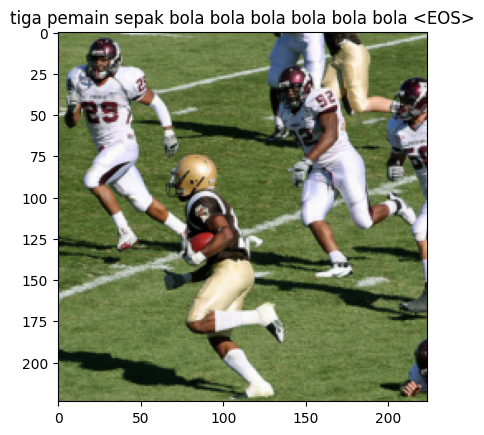

809it [03:23,  3.98it/s]


Model Improved at Epoch: 1
Epoch: 1/100
Decoder Loss: 4.7276
BLEU Score: [0.40979085 0.2629466  0.15914351 0.10394129]
Decoder scheduler is running
Epoch 2 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:20<00:00,  1.27s/it]


Validating...


806it [03:35,  3.90it/s]

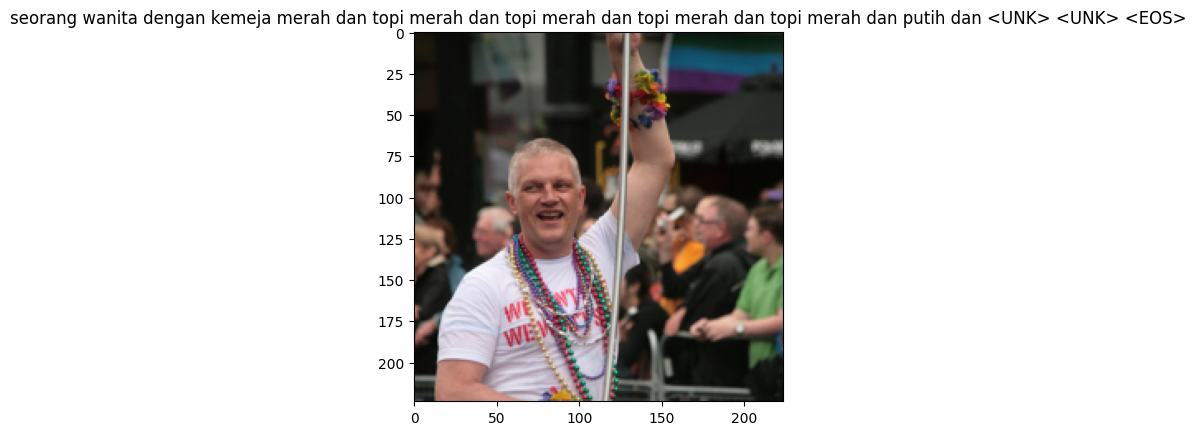

809it [03:36,  3.74it/s]


Model Improved at Epoch: 2
Epoch: 2/100
Decoder Loss: 3.7338
BLEU Score: [0.35425575 0.2429754  0.15748319 0.10454808]
Decoder scheduler is running
Epoch 3 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:23<00:00,  1.28s/it]


Validating...


806it [02:37,  4.49it/s]

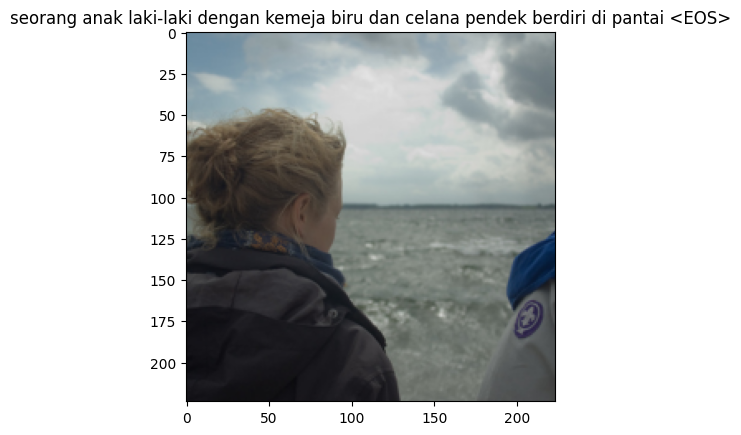

809it [02:37,  5.13it/s]


Model Improved at Epoch: 3
Epoch: 3/100
Decoder Loss: 3.4143
BLEU Score: [0.43312423 0.29621545 0.19180173 0.12682905]
Decoder scheduler is running
Epoch 4 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:25<00:00,  1.29s/it]


Validating...


805it [02:16,  6.61it/s]

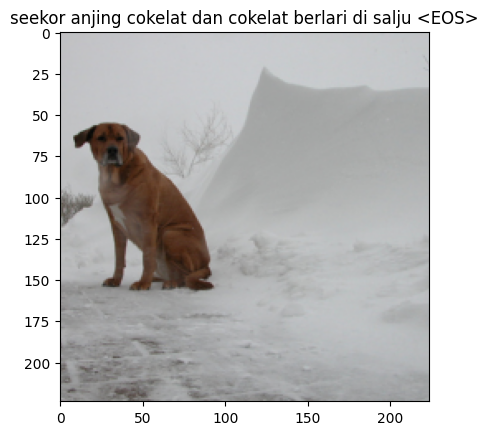

809it [02:16,  5.91it/s]


Model Improved at Epoch: 4
Epoch: 4/100
Decoder Loss: 3.2397
BLEU Score: [0.43525253 0.29398208 0.19365723 0.13334611]
Decoder scheduler is running
Epoch 5 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:23<00:00,  1.28s/it]


Validating...


806it [02:07,  7.35it/s]

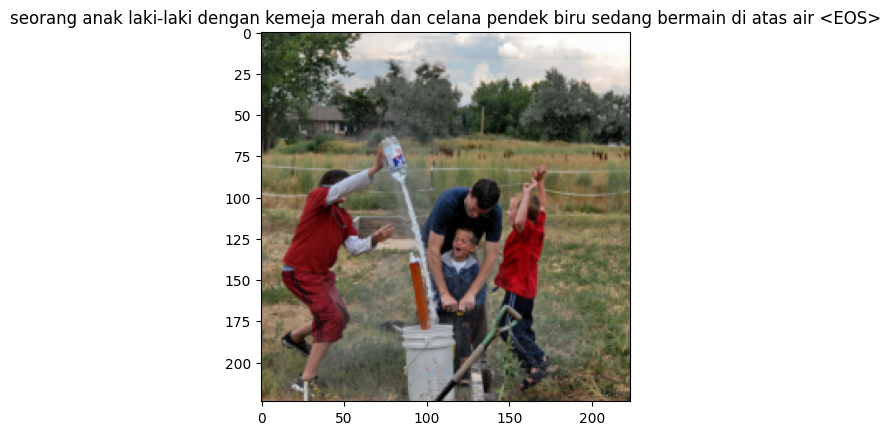

809it [02:09,  6.26it/s]


Model Improved at Epoch: 5
Epoch: 5/100
Decoder Loss: 3.1068
BLEU Score: [0.49338232 0.33734339 0.22176131 0.15172237]
Decoder scheduler is running
Epoch 6 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:26<00:00,  1.29s/it]


Validating...


806it [02:03,  8.36it/s]

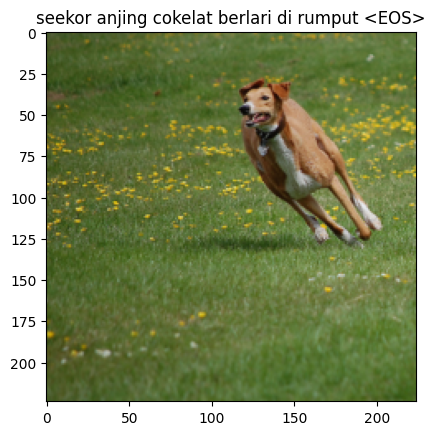

809it [02:04,  6.52it/s]


Model Improved at Epoch: 6
Epoch: 6/100
Decoder Loss: 2.9972
BLEU Score: [0.47787503 0.33210185 0.22251829 0.15600977]
Decoder scheduler is running
Epoch 7 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:32<00:00,  1.31s/it]


Validating...


806it [01:50,  7.32it/s]

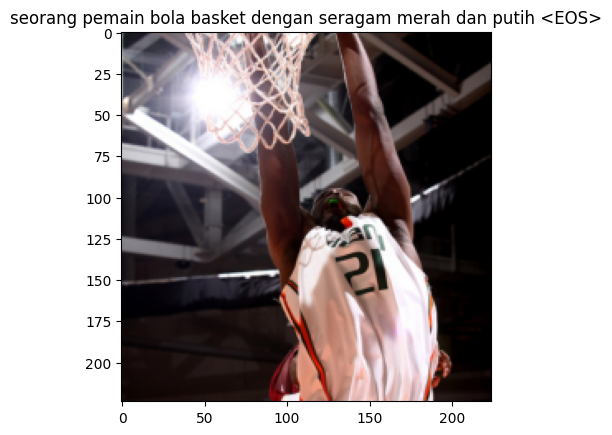

809it [01:50,  7.31it/s]


Model Improved at Epoch: 7
Epoch: 7/100
Decoder Loss: 2.9084
BLEU Score: [0.5036848  0.3496712  0.23286934 0.15944079]
Decoder scheduler is running
Epoch 8 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:33<00:00,  1.32s/it]


Validating...


806it [01:51,  7.50it/s]

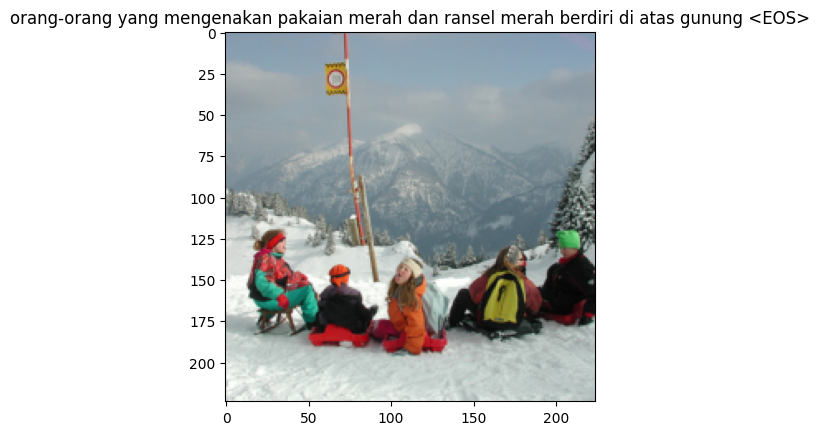

809it [01:52,  7.18it/s]


Model Improved at Epoch: 8
Epoch: 8/100
Decoder Loss: 2.8271
BLEU Score: [0.50868554 0.35253671 0.23842942 0.16554289]
Decoder scheduler is running
Epoch 9 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:25<00:00,  1.29s/it]


Validating...


805it [01:43,  6.08it/s]

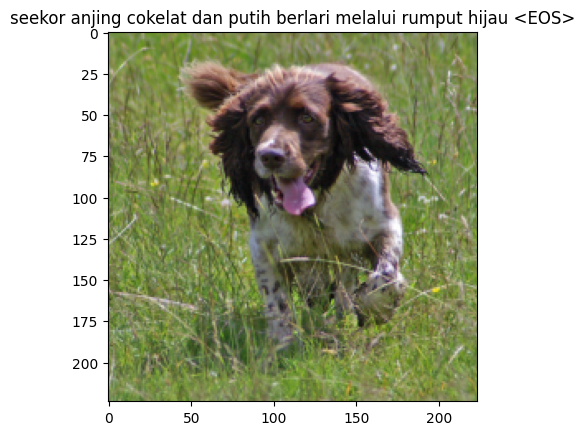

809it [01:44,  7.73it/s]


Model Improved at Epoch: 9
Epoch: 9/100
Decoder Loss: 2.7548
BLEU Score: [0.53456452 0.37361014 0.25255377 0.17440828]
Decoder scheduler is running
Epoch 10 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:24<00:00,  1.28s/it]


Validating...


806it [01:50,  9.80it/s]

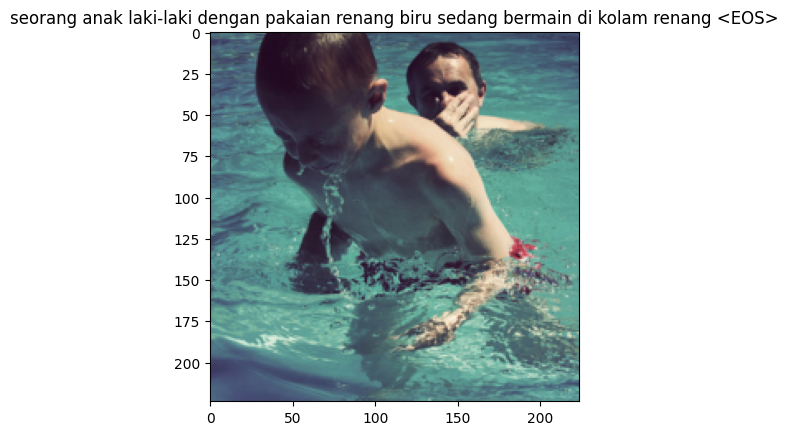

809it [01:51,  7.28it/s]


Epoch: 10/100
Decoder Loss: 2.6870
BLEU Score: [0.53007713 0.36487862 0.24069444 0.16325476]
Decoder scheduler is running
Epoch 11 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:27<00:00,  1.29s/it]


Validating...


805it [01:51,  7.73it/s]

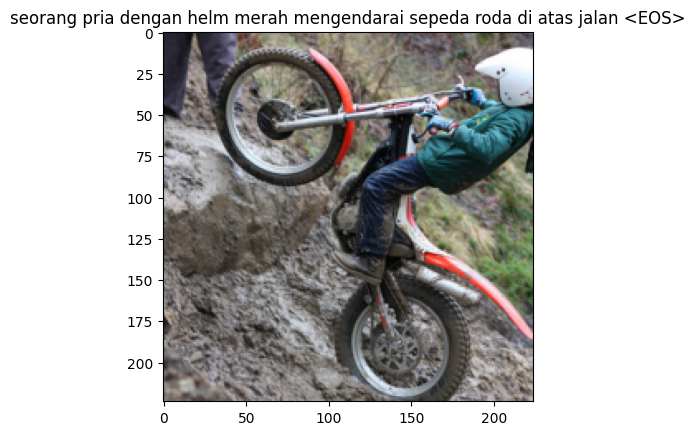

809it [01:52,  7.22it/s]


Epoch: 11/100
Decoder Loss: 2.6273
BLEU Score: [0.51309308 0.35425328 0.23834326 0.16796119]
Decoder scheduler is running
Epoch 12 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:23<00:00,  1.28s/it]


Validating...


805it [01:56,  5.63it/s]

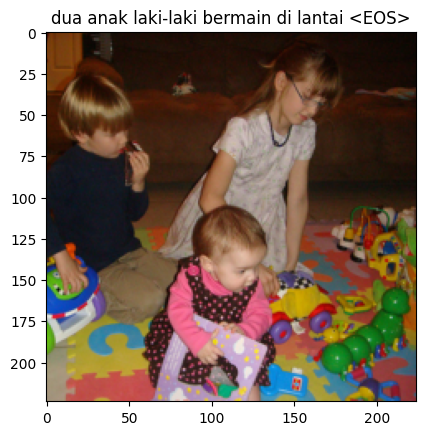

809it [01:56,  6.92it/s]


Epoch: 12/100
Decoder Loss: 2.5704
BLEU Score: [0.53155624 0.36825229 0.24909221 0.17300062]
Decoder scheduler is running
Epoch 13 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:22<00:00,  1.28s/it]


Validating...


806it [4:30:06,  2.67it/s]  

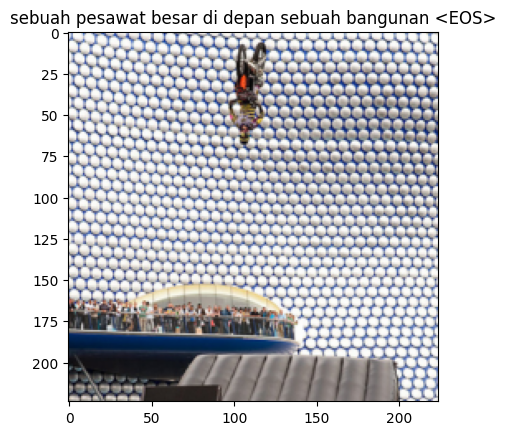

809it [4:30:08, 20.03s/it]


Epoch: 13/100
Decoder Loss: 2.5103
BLEU Score: [0.51598653 0.35782176 0.24313486 0.17185637]
Decoder scheduler is running
Epoch 14 :


100%|█████████████████████████████████████████████████████████████████████| 253/253 [7:58:57<00:00, 113.59s/it]


Validating...


806it [01:38,  8.71it/s]

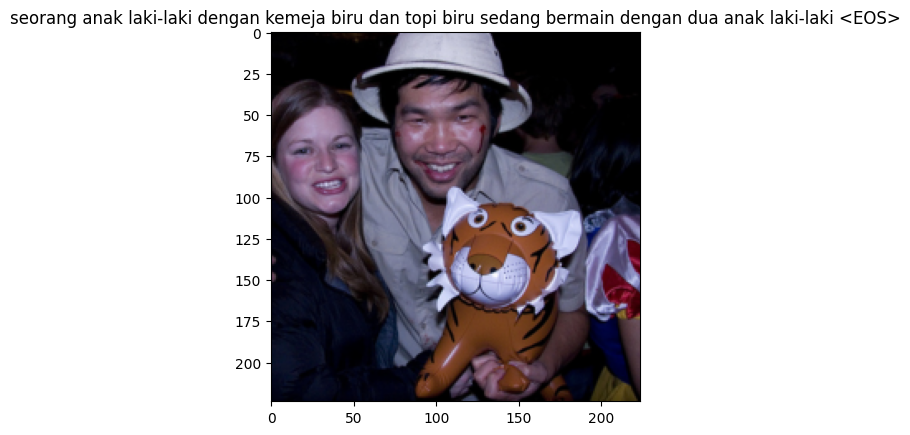

809it [01:39,  8.16it/s]


Epoch: 14/100
Decoder Loss: 2.4551
BLEU Score: [0.5213754  0.36102114 0.24339234 0.17281978]
Decoder scheduler is running
Epoch 15 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:13<00:00,  1.24s/it]


Validating...


806it [01:55,  6.10it/s]

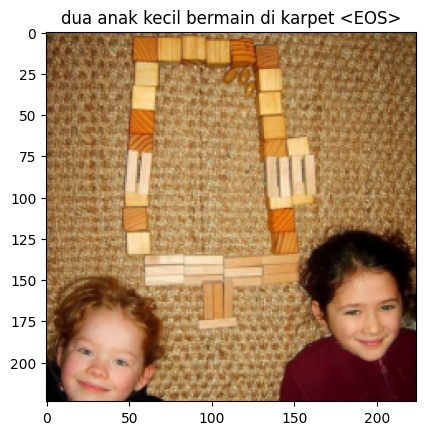

809it [01:56,  6.97it/s]


Epoch: 15/100
Decoder Loss: 2.4045
BLEU Score: [0.50197293 0.34743053 0.23164845 0.1589864 ]
Decoder scheduler is running
Epoch 16 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:14<00:00,  1.24s/it]


Validating...


806it [01:44,  6.66it/s]

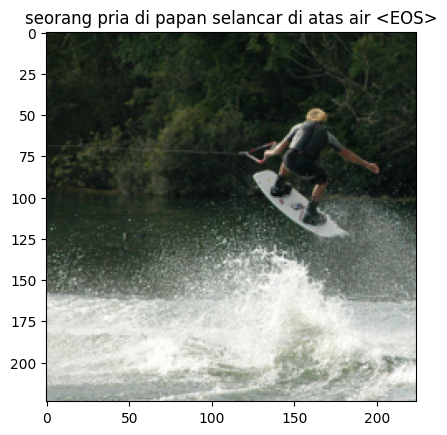

809it [01:44,  7.72it/s]


Epoch: 16/100
Decoder Loss: 2.3509
BLEU Score: [0.52171434 0.3627691  0.24466786 0.17077553]
Decoder scheduler is running
Epoch 17 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:13<00:00,  1.24s/it]


Validating...


806it [01:43,  8.90it/s]

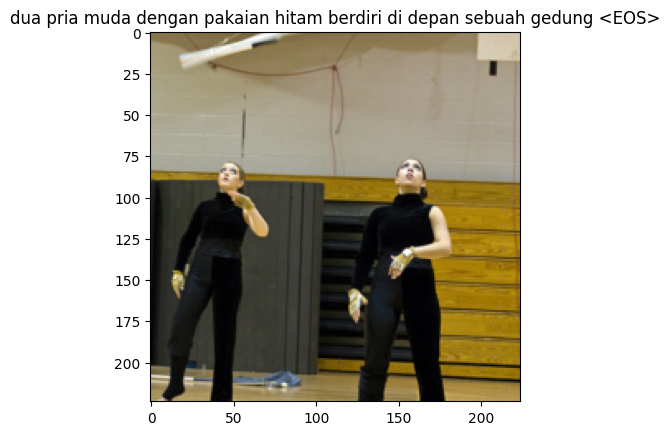

809it [01:44,  7.73it/s]


Epoch: 17/100
Decoder Loss: 2.3051
BLEU Score: [0.50844227 0.3470796  0.23195488 0.16002373]
Decoder scheduler is running
Epoch 18 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:16<00:00,  1.25s/it]


Validating...


806it [01:43,  8.76it/s]

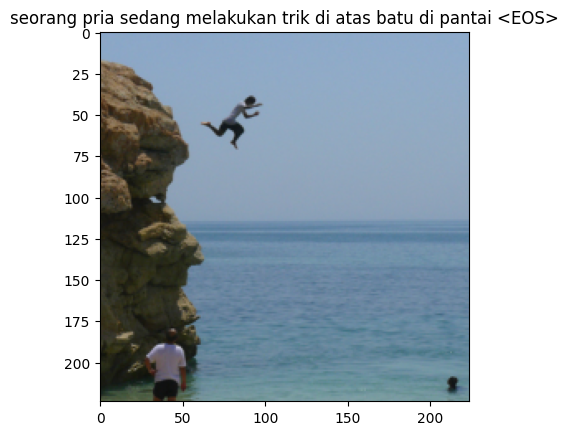

809it [01:44,  7.76it/s]


Epoch: 18/100
Decoder Loss: 2.2592
BLEU Score: [0.52253993 0.36180643 0.24365637 0.1695021 ]
Decoder scheduler is running
Epoch 19 :


100%|████████████████████████████████████████████████████████████████████████| 253/253 [05:12<00:00,  1.23s/it]


Validating...


806it [01:38,  7.58it/s]

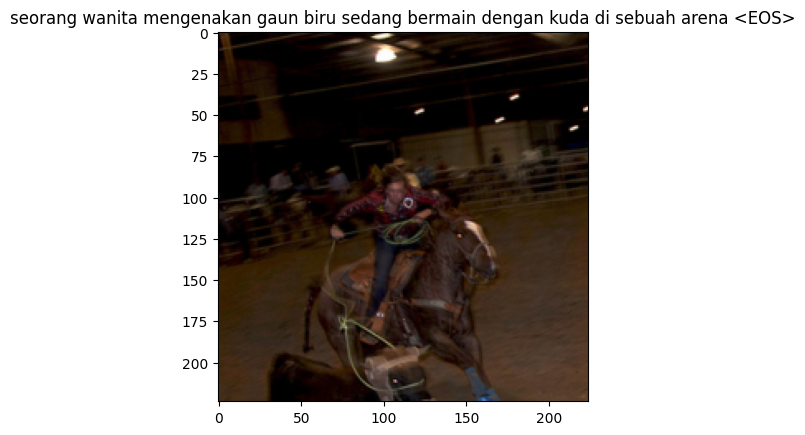

809it [01:39,  8.16it/s]


Epoch: 19/100
Decoder Loss: 2.2116
BLEU Score: [0.51268875 0.35254104 0.23435006 0.16020284]
Decoder scheduler is running
Early stopping at epoch 19 due to no improvement in BLEU score


In [39]:
num_epochs = 100
loss_history = []

if is_new_model:
    loss_history = train_model(model, data_loader, num_epochs, device)

<h1>11. Plot Loss Model</h1>

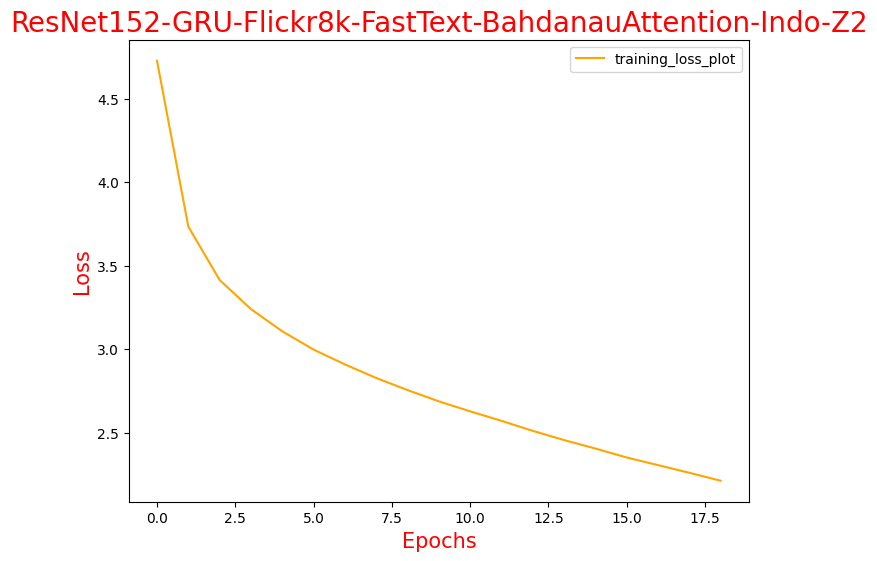

In [40]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(loss_history[1], color='orange', label = 'training_loss_plot')
# plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title(pin_name, fontsize = 20, color = 'red')
plt.legend()
plt.savefig('plot/'+pin_name+".png")
plt.show()

<h1>12. Visualizing the attentions</h1>
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [41]:
#generate caption
def get_caps_from(features_tensors, show=False):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        if show:
            show_image(features_tensors[0],title=caption)
    
    return caps, alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    num_rows = len(result) // 2 + len(result) % 2  # Add 1 row if len(result) is odd
    num_cols = 5
        
    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(num_rows, num_cols, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

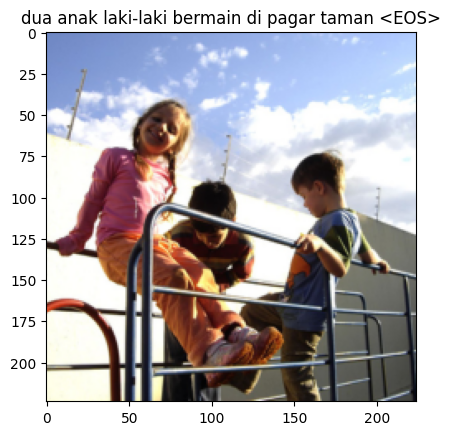

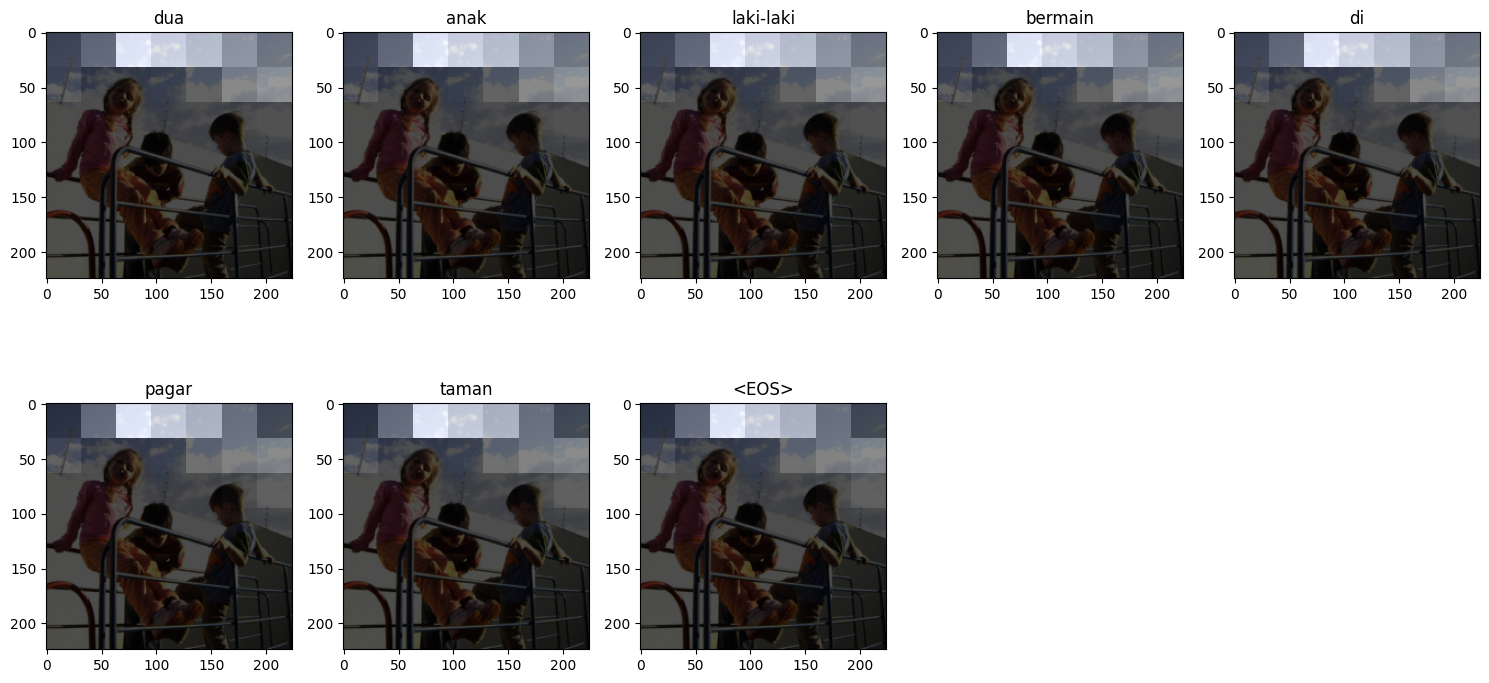

In [42]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0), True)

plot_attention(img1, caps, alphas)

<h1>13. Test Data</h1>

In [43]:
import pandas as pd
df_test = pd.read_csv(dataset_dir+'/flickr8k-id-fin-test.csv')
df_test.head()

image  \
0  1001773457_577c3a7d70.jpg   
1  1001773457_577c3a7d70.jpg   
2  1001773457_577c3a7d70.jpg   
3  1001773457_577c3a7d70.jpg   
4  1001773457_577c3a7d70.jpg   

                                             caption  
0  Seekor anjing hitam dan seekor anjing tutul be...  
1  Seekor anjing hitam dan anjing tiga warna berm...  
2  Seekor anjing hitam dan seekor anjing putih de...  
3  Dua anjing dari berbagai ras saling memandang ...  
4  Dua anjing di trotoar saling memandang satu sa...

In [44]:
test_list = df_test['image'].unique().tolist()

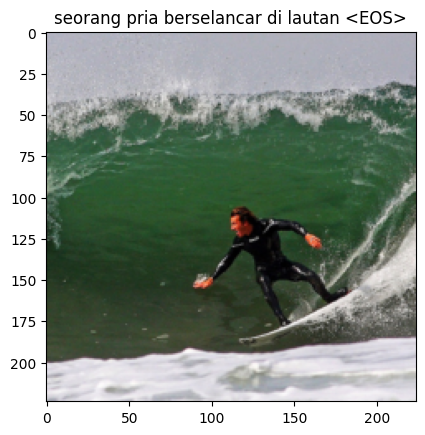

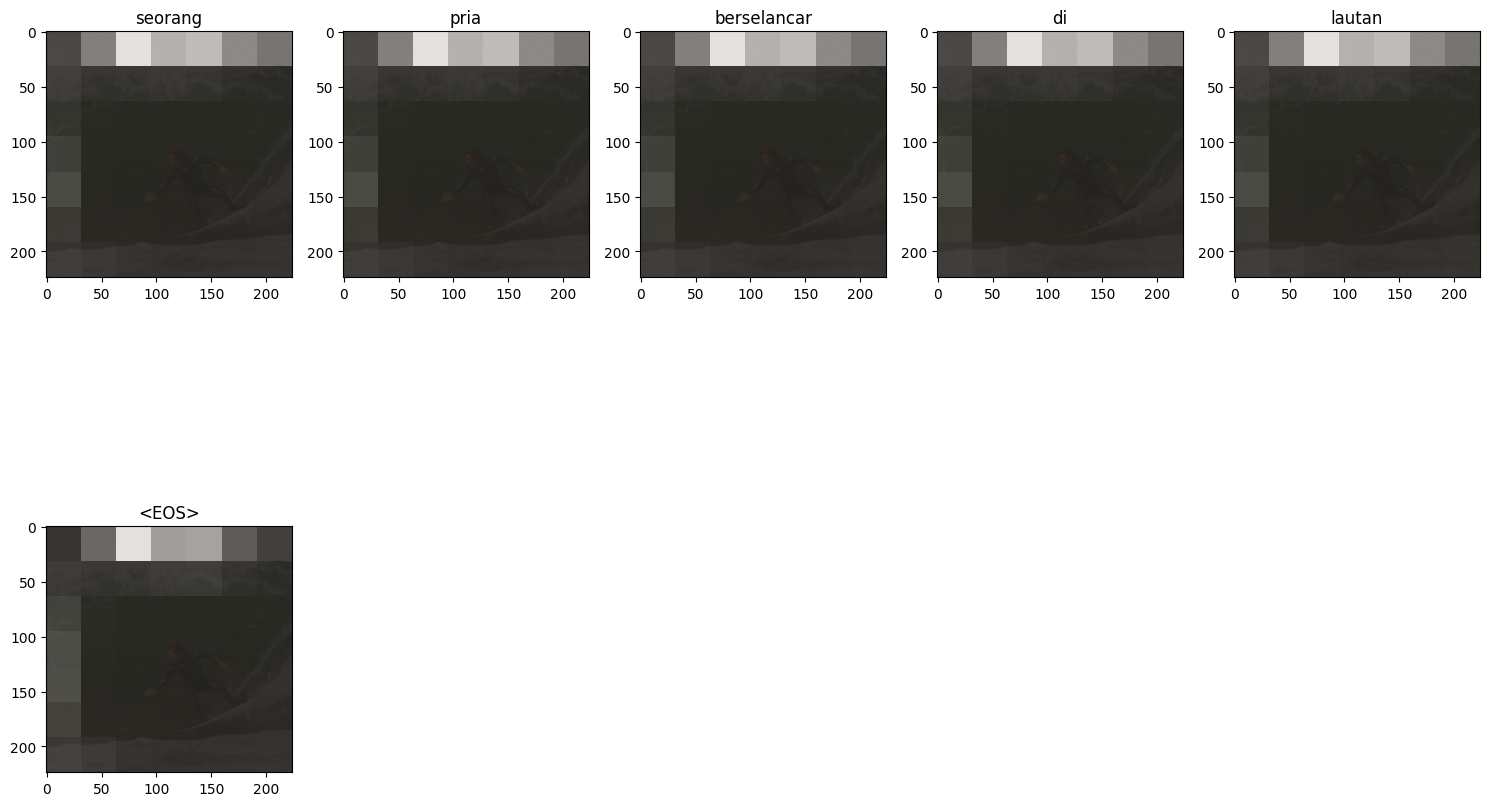

In [45]:
# from IPython.display import display
from PIL import Image

random_row = df_test.sample(n=1)
img_file = random_row['image'].iloc[0]
# img_file = '1271960365_e54033f883.jpg'

# Load the image
select_img = dataset_dir+'/images/'+img_file
img = Image.open(select_img).convert('RGB')

# Define transformations to preprocess the image
tr = T.Compose([
    T.Resize(224),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# Preprocess the image
img_tensor = tr(img)

# Add batch dimension as your model expects it
img_tensor = img_tensor.unsqueeze(0)

# Get captions and attention weights
caps, alphas = get_caps_from(img_tensor, True)

# # Visualize attention weights
plot_attention(img_tensor.squeeze(0), caps, alphas)

In [46]:
print("Image Name : ", img_file)
bleus = check_bleu(img_file, ' '.join(caps), df_test)
print("Bleu Scores: ", bleus)

Image Name :  3126981064_1e803c3d7f.jpg
Bleu Scores:  [1.0, 1.0, 0.6934, 0.3593]


In [47]:
# %%capture
import time

bleus = []
for record in tqdm(test_list, total=len(test_list)):

    # Load the image
    select_img = dataset_dir+'/images/'+record
    img = Image.open(select_img).convert('RGB')
    
    # Define transformations to preprocess the image
    tr = T.Compose([
        T.Resize(224),                     
        T.RandomCrop(224),                 
        T.ToTensor(),                               
        T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
    
    # Preprocess the image
    img_tensor = tr(img)
    
    # Add batch dimension as your model expects it
    img_tensor = img_tensor.unsqueeze(0)
    
    # Get captions and attention weights
    caps, alphas = get_caps_from(img_tensor)
    
    # # Visualize attention weights
    # plot_attention(img_tensor.squeeze(0), caps, alphas)
    
    # reference_captions = df_test.loc[df_test['image'] == record]['caption'].tolist()
    
    bleu = check_bleu(record, ' '.join(caps), df_test)
    
    bleus.append({
        'image':record,
        'caption': ' '.join(caps),
        # 'reference_captions': reference_captions,
        'bleu_1':bleu[0],
        'bleu_2':bleu[1],
        'bleu_3':bleu[2],
        'bleu_4':bleu[3],
    })
    
    # time.sleep(1)

100%|████████████████████████████████████████████████████████████████████████| 810/810 [01:42<00:00,  7.93it/s]


In [48]:
bleus[101]

{'image': '1561658940_a947f2446a.jpg',
 'caption': 'seorang gadis kecil berayun di ayunan <EOS>',
 'bleu_1': 1.0,
 'bleu_2': 1.0,
 'bleu_3': 1.0,
 'bleu_4': 1.0}

In [49]:
bleus_data = pd.DataFrame(bleus)
pd.set_option('display.max_colwidth', None)
bleus_data.head()

image  \
0  1001773457_577c3a7d70.jpg   
1  1009434119_febe49276a.jpg   
2  1015584366_dfcec3c85a.jpg   
3  1030985833_b0902ea560.jpg   
4   103195344_5d2dc613a3.jpg   

                                                                                      caption  \
0                                            dua anjing kecil bermain dengan bola tenis <EOS>   
1                                  seekor anjing hitam dan putih berlari di atas rumput <EOS>   
2                                                 seekor anjing hitam melompat di udara <EOS>   
3                                seekor anjing hitam bermain dengan mainan kunyah merah <EOS>   
4  seorang anak laki-laki dengan kemeja hijau melompat di udara di atas sebuah bangunan <EOS>   

   bleu_1  bleu_2  bleu_3  bleu_4  
0  0.4954  0.2675  0.1075  0.0720  
1  1.0000  1.0000  1.0000  1.0000  
2  0.5000  0.4472  0.3684  0.2021  
3  0.7722  0.6240  0.4857  0.2120  
4  0.4615  0.1961  0.0704  0.0432

In [50]:
{
    'bleu_1': bleus_data['bleu_1'].mean(),
    'bleu_2': bleus_data['bleu_2'].mean(),
    'bleu_3': bleus_data['bleu_3'].mean(),
    'bleu_4': bleus_data['bleu_4'].mean(),
}

{'bleu_1': 0.6145602469135802,
 'bleu_2': 0.46410679012345674,
 'bleu_3': 0.33017506172839506,
 'bleu_4': 0.23300901234567903}

In [51]:
# bleus_data.to_excel(dataset_dir+'/train-'+pin_name+'.xlsx')

In [52]:
bleus_data.to_excel('result/'+pin_name+'.xlsx')